In [200]:
#I synchronize two time series - using crosscorrelation I  find optimal delay for the noisy series to 
#synchronize them, try to play with test_function, delay, flag, noise:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal

real_delay = 0.4

#Can be only 0 or 1
flag_periodic = 1
noise = 0.05
def test_function(t): return np.exp(t*1.5)* np.sin(2*np.pi*t) + np.cos(2*np.pi*0.2*t)

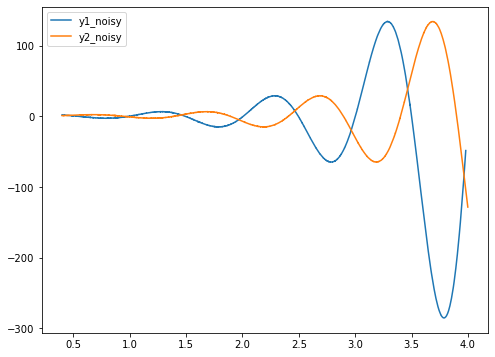

Start Time: 0.4001589251382264


In [201]:
# Generate the time series with random windows
t1 = np.sort(np.random.uniform(low=0, high=4, size=10000))
t2 = np.sort(np.random.uniform(low=0, high=4, size=10000)) 

y1 = test_function(t1)
y2 = test_function(t2) 

t2 += real_delay

# Add noise to both time series
y1_noisy = y1 + np.random.normal(0, noise, len(y1))
y2_noisy = y2 + np.random.normal(0, noise, len(y2))

id1 = np.searchsorted(t1, t2[0])
id2 = np.searchsorted(t2, t1[-1])

trunc_y1_noisy = y1_noisy[id1:]
trunc_t1 = t1[id1:]

trunc_y2_noisy = y2_noisy[:id2]
trunc_t2 = t2[:id2]

# Truncate to be the same length
if len(trunc_y1_noisy) >= len(trunc_y2_noisy):
    trunc_y1_noisy = trunc_y1_noisy[:-(len(trunc_y1_noisy) - len(trunc_y2_noisy))]
    trunc_t1 = trunc_t1[:-(len(trunc_t1) - len(trunc_t2))]
elif len(trunc_y1_noisy) < len(trunc_y2_noisy):
    trunc_y2_noisy = trunc_y2_noisy[:-(len(trunc_y2_noisy) - len(trunc_y1_noisy))]
    trunc_t2 = trunc_t2[:-(len(trunc_t2) - len(trunc_t1))]

assert len(trunc_y1_noisy) == len(trunc_y2_noisy) , 'Different length'
assert len(trunc_y1_noisy) == len(trunc_t1), 'Different length'
assert len(trunc_t1) == len(trunc_t2), 'Different length'

# Plot the original and shifted time series
plt.figure(figsize=(8,6))
plt.plot(trunc_t1, trunc_y1_noisy, label='y1_noisy')
plt.plot(trunc_t2, trunc_y2_noisy, label='y2_noisy')
plt.legend()
plt.show()

print("Start Time: " + str(min(trunc_t1[0], trunc_t2[0])))

/home/cheytakker/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


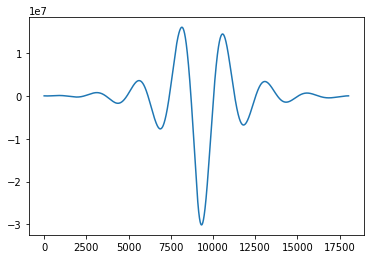

In [202]:
# Compute cross correlation
# corr = np.correlate(trunc_y1_noisy, trunc_y2_noisy, mode='full')
#This one uses FFT:
# corr = scipy.signal.correlate(trunc_y1_noisy, trunc_y2_noisy, mode='full')

n1 = len(trunc_y1_noisy)
n2 = len(trunc_y2_noisy)
corr = np.fft.ifft(np.fft.fft(trunc_y1_noisy, n1+n2-1) * np.conj(np.fft.fft(trunc_y2_noisy, n1+n2-1)))
corr = np.concatenate((corr[-(n1-1):], corr[:n2]))

plt.plot(corr)

In [203]:
# Find the delay just using the maximum
delay = (np.argmax(corr) - len(y1_noisy) - 1) // (flag_periodic + 1)
print("Estimated delay: " + str(delay) +" or ~ " + str(t1[abs(delay)]-t1[0]) + " seconds")

# Shift the second time series
trunc_y2_noisy_shifted = np.zeros_like(trunc_y2_noisy)

if delay >= 0:
    trunc_y2_noisy_shifted[delay:] = trunc_y2_noisy[:len(trunc_y2_noisy)-delay]
else:
    trunc_y2_noisy_shifted[:len(trunc_y2_noisy) + delay] = trunc_y2_noisy[-delay:]

trunc_y2_noisy_shifted = np.trim_zeros(trunc_y2_noisy_shifted)
trunc_t2_shifted = trunc_t2[:len(trunc_y2_noisy_shifted)]

trunc_y2_noisy_shifted = np.trim_zeros(trunc_y2_noisy_shifted, trim='f')
trunc_t2_shifted = trunc_t2_shifted[len(trunc_t2_shifted)-len(trunc_y2_noisy_shifted):]

assert len(trunc_y2_noisy_shifted) == len(trunc_t2_shifted), 'Different length'

Estimated delay: -921 or ~ 0.3955902389658097 seconds


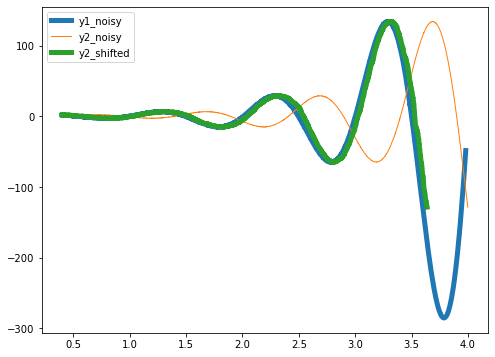

In [204]:
# Plot the original and shifted time series
plt.figure(figsize=(8,6))
plt.plot(trunc_t1, trunc_y1_noisy, label='y1_noisy', linewidth=5)
plt.plot(trunc_t2, trunc_y2_noisy, label='y2_noisy', linewidth=1)
plt.plot(trunc_t2_shifted, trunc_y2_noisy_shifted, label='y2_shifted', linewidth=5)
plt.legend()
plt.show()
#Sometimes is wrong due to the spectral leakage since the function is not periodic

/home/cheytakker/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


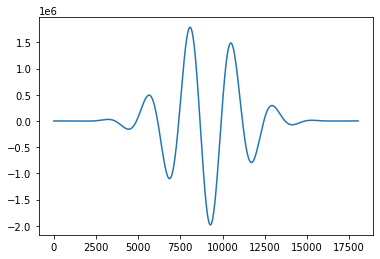

In [205]:
# Apply Hann window to cross-correlation
window = np.hanning(len(trunc_y1_noisy))
trunc_y1_noisy_hann = trunc_y1_noisy * window
trunc_y2_noisy_hann = trunc_y2_noisy * window
# Compute cross correlation
# corr_hann = np.correlate(trunc_y1_noisy_hann, trunc_y2_noisy_hann, mode='full')
# corr_hann = scipy.signal.correlate(trunc_y1_noisy_hann, trunc_y2_noisy_hann, mode='full')


n1 = len(trunc_y1_noisy_hann)
n2 = len(trunc_y2_noisy_hann)
corr = np.fft.ifft(np.fft.fft(trunc_y1_noisy_hann, n1+n2-1) * np.conj(np.fft.fft(trunc_y2_noisy_hann, n1+n2-1)))
corr = np.concatenate((corr[-(n1-1):], corr[:n2]))


plt.plot(corr)

In [206]:
# Find time delay_hann
delay_hann = (np.argmax(corr_hann) - len(y1_noisy) - 1) // (flag_periodic + 1)

print("Estimated delay: " + str(delay_hann) +" or ~ " + str(t1[abs(delay_hann)]-t1[0]) + " seconds")
print("While previous estimated delay: " + str(delay) +" or ~ " + str(t1[abs(delay)]-t1[0]) + " seconds")

# Shift the second time series
trunc_y2_noisy_shifted_hann = np.zeros_like(trunc_y2_noisy)

if delay_hann >= 0:
    trunc_y2_noisy_shifted_hann[delay_hann:] = trunc_y2_noisy[:len(trunc_y2_noisy)-delay_hann]
else:
    trunc_y2_noisy_shifted_hann[:len(trunc_y2_noisy) + delay_hann] = trunc_y2_noisy[-delay_hann:]

trunc_y2_noisy_shifted_hann = np.trim_zeros(trunc_y2_noisy_shifted_hann)
trunc_t2_shifted_hann = trunc_t2[:len(trunc_y2_noisy_shifted_hann)]

trunc_y2_noisy_shifted_hann = np.trim_zeros(trunc_y2_noisy_shifted_hann, trim='f')
trunc_t2_shifted_hann = trunc_t2_shifted_hann[len(trunc_t2_shifted_hann)-len(trunc_y2_noisy_shifted_hann):]

assert len(trunc_y2_noisy_shifted_hann) == len(trunc_t2_shifted_hann), 'Different length'


Estimated delay: -982 or ~ 0.419135104279067 seconds
While previous estimated delay: -921 or ~ 0.3955902389658097 seconds


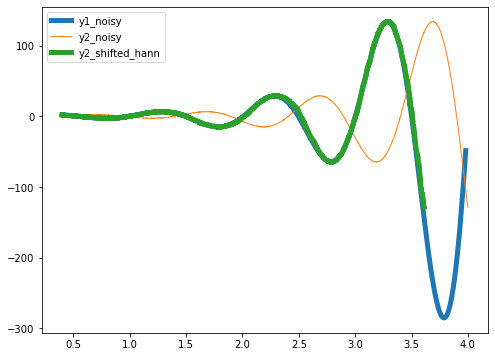

In [207]:
# Plot the original and shifted time series
plt.figure(figsize=(8,6))
plt.plot(trunc_t1, trunc_y1_noisy, label='y1_noisy', linewidth=5)
plt.plot(trunc_t2, trunc_y2_noisy, label='y2_noisy', linewidth=1)
plt.plot(trunc_t2_shifted_hann, trunc_y2_noisy_shifted_hann, label='y2_shifted_hann', linewidth=5)
plt.legend()
plt.show()

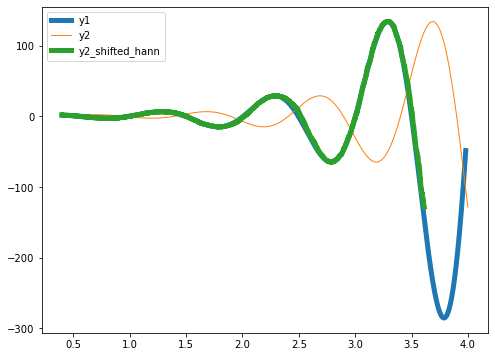

In [208]:
#Let's plot the same but without noise
# Plot the original and shifted time series
plt.figure(figsize=(8,6))
plt.plot(trunc_t1, y1[np.searchsorted(t1, trunc_t1[0]):np.searchsorted(t1, trunc_t1[-1])+1], label='y1', linewidth=5)
plt.plot(trunc_t2, y2[np.searchsorted(t2, trunc_t2[0]):np.searchsorted(t2, trunc_t2[-1])+1], label='y2', linewidth=1)
plt.plot(trunc_t2_shifted_hann, trunc_y2_noisy_shifted_hann, label='y2_shifted_hann', linewidth=5)
plt.legend()
plt.show()

In [209]:
def trial(real_delay):
    # Generate the time series wit random windows
    t1 = np.sort(np.random.uniform(low=0, high=4, size=10000))
    t2 = np.sort(np.random.uniform(low=0, high=4, size=10000)) 

    y1 = test_function(t1)
    y2 = test_function(t2)

    t2 += real_delay

    # Add noise to both time series
    y1_noisy = y1 + np.random.normal(0, noise, len(y1))
    y2_noisy = y2 + np.random.normal(0, noise, len(y2))

    id1 = np.searchsorted(t1, t2[0])
    id2 = np.searchsorted(t2, t1[-1])

    trunc_y1_noisy = y1_noisy[id1:]
    trunc_t1 = t1[id1:]

    trunc_y2_noisy = y2_noisy[:id2]
    trunc_t2 = t2[:id2]

    # Truncate to be the same length
    if len(trunc_y1_noisy) > len(trunc_y2_noisy):
        trunc_y1_noisy = trunc_y1_noisy[:-(len(trunc_y1_noisy) - len(trunc_y2_noisy))]
        trunc_t1 = trunc_t1[:-(len(trunc_t1) - len(trunc_t2))]
    elif len(trunc_y1_noisy) < len(trunc_y2_noisy):
        trunc_y2_noisy = trunc_y2_noisy[:-(len(trunc_y2_noisy) - len(trunc_y1_noisy))]
        trunc_t2 = trunc_t2[:-(len(trunc_t2) - len(trunc_t1))]

    assert len(trunc_y1_noisy) == len(trunc_y2_noisy) , 'Different length ' + str(len(trunc_y1_noisy)) + " vs " + str(len(trunc_y2_noisy)) 
    
    assert len(trunc_y1_noisy) == len(trunc_t1), 'Different length'
    assert len(trunc_t1) == len(trunc_t2), 'Different length'
#     corr = np.correlate(trunc_y1_noisy, trunc_y2_noisy, mode='full')
#     corr = scipy.signal.correlate(trunc_y1_noisy, trunc_y2_noisy, mode='full')
    n1 = len(trunc_y1_noisy)
    n2 = len(trunc_y2_noisy)
    corr = np.fft.ifft(np.fft.fft(trunc_y1_noisy, n1+n2-1) * np.conj(np.fft.fft(trunc_y2_noisy, n1+n2-1)))
    corr = np.concatenate((corr[-(n1-1):], corr[:n2]))
    
    # Find the delay just using the maximum
    
    delay = (np.argmax(corr) - len(y1_noisy) - 1) // (flag_periodic + 1)


    # Shift the second time series
    trunc_y2_noisy_shifted = np.zeros_like(trunc_y2_noisy)

    if delay >= 0:
        trunc_y2_noisy_shifted[delay:] = trunc_y2_noisy[:len(trunc_y2_noisy)-delay]
    else:
        trunc_y2_noisy_shifted[:len(trunc_y2_noisy) + delay] = trunc_y2_noisy[-delay:]

    trunc_y2_noisy_shifted = np.trim_zeros(trunc_y2_noisy_shifted)
    trunc_t2_shifted = trunc_t2[:len(trunc_y2_noisy_shifted)]

    trunc_y2_noisy_shifted = np.trim_zeros(trunc_y2_noisy_shifted, trim='f')
    trunc_t2_shifted = trunc_t2_shifted[len(trunc_t2_shifted)-len(trunc_y2_noisy_shifted):]

    assert len(trunc_y2_noisy_shifted) == len(trunc_t2_shifted), 'Different length' 
    # Apply Hann window to cross-correlation
    window = np.hanning(len(trunc_y1_noisy))
    trunc_y1_noisy_hann = trunc_y1_noisy * window
    trunc_y2_noisy_hann = trunc_y2_noisy * window
    # Compute cross correlation
#     corr_hann = np.correlate(trunc_y1_noisy_hann, trunc_y2_noisy_hann, mode='full')
#     corr_hann = scipy.signal.correlate(trunc_y1_noisy_hann, trunc_y2_noisy_hann, mode='full')
    n1 = len(trunc_y1_noisy_hann)
    n2 = len(trunc_y2_noisy_hann)
    corr = np.fft.ifft(np.fft.fft(trunc_y1_noisy_hann, n1+n2-1) * np.conj(np.fft.fft(trunc_y2_noisy_hann, n1+n2-1)))
    corr = np.concatenate((corr[-(n1-1):], corr[:n2]))

    # Find time delay_hann
    delay_hann = (np.argmax(corr_hann) - len(y1_noisy) - 1) // (flag_periodic + 1)

    # Shift the second time series
    trunc_y2_noisy_shifted_hann = np.zeros_like(trunc_y2_noisy)

    if delay_hann >= 0:
        trunc_y2_noisy_shifted_hann[delay_hann:] = trunc_y2_noisy[:len(trunc_y2_noisy)-delay_hann]
    else:
        trunc_y2_noisy_shifted_hann[:len(trunc_y2_noisy) + delay_hann] = trunc_y2_noisy[-delay_hann:]

    trunc_y2_noisy_shifted_hann = np.trim_zeros(trunc_y2_noisy_shifted_hann)
    trunc_t2_shifted_hann = trunc_t2[:len(trunc_y2_noisy_shifted_hann)]

    trunc_y2_noisy_shifted_hann = np.trim_zeros(trunc_y2_noisy_shifted_hann, trim='f')
    trunc_t2_shifted_hann = trunc_t2_shifted_hann[len(trunc_t2_shifted_hann)-len(trunc_y2_noisy_shifted_hann):]

    assert len(trunc_y2_noisy_shifted_hann) == len(trunc_t2_shifted_hann), 'Different length'
    return (t1[abs(delay)], t1[abs(delay_hann)])

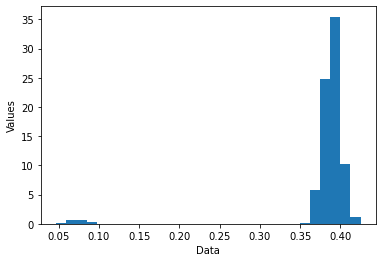

In [210]:
answers = []
for i in range(1000):
    answers.append(trial(real_delay))
    
df = pd.DataFrame(answers)
plt.hist(df.iloc[:,[0]], density=True, bins=30)  
plt.ylabel('Values')
plt.xlabel('Data');

0    0.047645
1    0.011937
dtype: float64

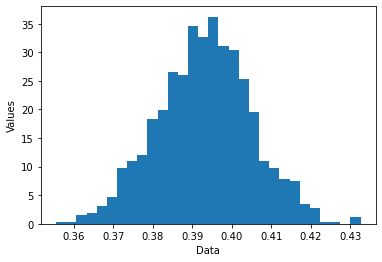

In [211]:
plt.hist(df.iloc[:,[1]], density=True, bins=30)  
plt.ylabel('Values')
plt.xlabel('Data');
df.std()

In [212]:
df.mean()

0    0.382489
1    0.393140
dtype: float64